In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3


In [2]:
con = sqlite3.connect("classic.db")

In [3]:
# Consulta de productos más vendidos y sus ingresos
q = """
SELECT 
    p.productName,
    SUM(od.quantityOrdered) AS unidades_totales,              
    ROUND(SUM(od.quantityOrdered * od.priceEach), 2) AS ingresos_totales
    FROM orderDetails od
INNER JOIN products p ON od.productCode = p.productCode
GROUP BY p.productName
ORDER BY ingresos_totales DESC
"""

pd.read_sql(q, con)



,productName,unidades_totales,ingresos_totales
0,1992 Ferrari 360 Spider red,1808,276839.98
1,2001 Ferrari Enzo,1019,190755.86
2,1952 Alpine Renault 1300,961,190017.96
3,2003 Harley-Davidson Eagle Drag Bike,985,170686.00
4,1968 Ford Mustang,933,161531.48
...,...,...,...
104,1982 Ducati 996 R,906,33268.76
105,1958 Chevy Corvette Limited Edition,983,31627.96
106,1982 Lamborghini Diablo,912,30972.87
107,1936 Mercedes Benz 500k Roadster,824,29763.39


In [4]:
# Consulta de participación porcentual de ingresos por producto
q = """
WITH ventas AS (
    SELECT 
        p.productName,
        SUM(od.quantityOrdered) AS unidades_totales,
        ROUND(SUM(od.quantityOrdered * od.priceEach), 2) AS ingresos_totales
    FROM orderDetails od
    INNER JOIN products p ON od.productCode = p.productCode
    GROUP BY p.productName)
SELECT 
    productName,
    unidades_totales,
    ingresos_totales,
    ROUND((ingresos_totales * 100.0) / (SELECT SUM(ingresos_totales) FROM ventas), 2) AS porcentaje_participacion
FROM ventas
ORDER BY ingresos_totales DESC
"""
pd.read_sql(q, con)


,productName,unidades_totales,ingresos_totales,porcentaje_participacion
0,1992 Ferrari 360 Spider red,1808,276839.98,2.88
1,2001 Ferrari Enzo,1019,190755.86,1.99
2,1952 Alpine Renault 1300,961,190017.96,1.98
3,2003 Harley-Davidson Eagle Drag Bike,985,170686.00,1.78
4,1968 Ford Mustang,933,161531.48,1.68
...,...,...,...,...
104,1982 Ducati 996 R,906,33268.76,0.35
105,1958 Chevy Corvette Limited Edition,983,31627.96,0.33
106,1982 Lamborghini Diablo,912,30972.87,0.32
107,1936 Mercedes Benz 500k Roadster,824,29763.39,0.31


In [5]:
# Calcular precio promedio de venta por unidad
q_unidad = """
SELECT 
    p.productName,
    SUM(od.quantityOrdered) AS unidades_totales,              
    ROUND(SUM(od.quantityOrdered * od.priceEach), 2) AS ingresos_totales,
    ROUND(SUM(od.quantityOrdered * od.priceEach) / NULLIF(SUM(od.quantityOrdered), 0), 2) AS precio_promedio_unidad
FROM orderDetails od
INNER JOIN products p ON od.productCode = p.productCode
GROUP BY p.productName
ORDER BY precio_promedio_unidad DESC
"""
pd.read_sql(q_unidad, con)




,productName,unidades_totales,ingresos_totales,precio_promedio_unidad
0,1952 Alpine Renault 1300,961,190017.96,197.73
1,2001 Ferrari Enzo,1019,190755.86,187.20
2,2003 Harley-Davidson Eagle Drag Bike,985,170686.00,173.29
3,1968 Ford Mustang,933,161531.48,173.13
4,1969 Ford Falcon,965,152543.02,158.08
...,...,...,...,...
104,1982 Ducati 996 R,906,33268.76,36.72
105,1936 Mercedes Benz 500k Roadster,824,29763.39,36.12
106,1982 Lamborghini Diablo,912,30972.87,33.96
107,1958 Chevy Corvette Limited Edition,983,31627.96,32.17


In [6]:
# conversion a dataframe y mostrar las primeras 10 filas
df_productos = pd.read_sql(q, con)
df_productos.head(10)

,productName,unidades_totales,ingresos_totales,porcentaje_participacion
0,1992 Ferrari 360 Spider red,1808,276839.98,2.88
1,2001 Ferrari Enzo,1019,190755.86,1.99
2,1952 Alpine Renault 1300,961,190017.96,1.98
3,2003 Harley-Davidson Eagle Drag Bike,985,170686.00,1.78
4,1968 Ford Mustang,933,161531.48,1.68
5,1969 Ford Falcon,965,152543.02,1.59
6,1980s Black Hawk Helicopter,1040,144959.91,1.51
7,1998 Chrysler Plymouth Prowler,986,142530.63,1.48
8,1917 Grand Touring Sedan,918,140535.60,1.46
9,2002 Suzuki XREO,1028,135767.03,1.41


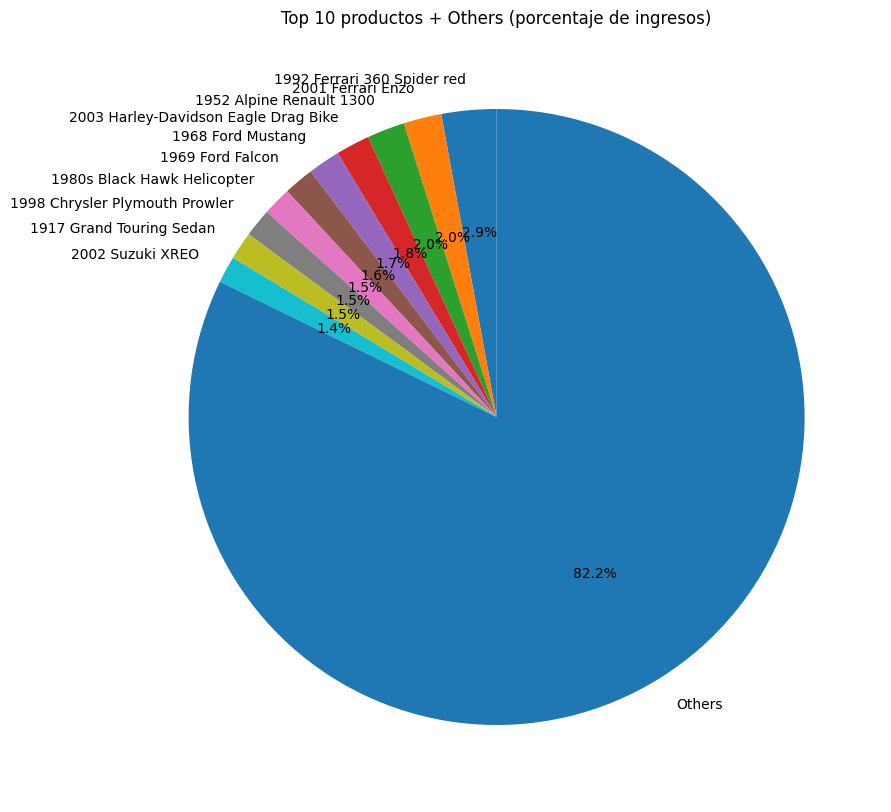

In [7]:
# Tomar los 10 primeros productos
df_top10 = df_productos.head(10)

# Calcular el total del resto
otros = pd.DataFrame({
    "productName": ["Others"],
    "porcentaje_participacion": [df_productos["porcentaje_participacion"].iloc[10:].sum()]
})

# Unir los 10 primeros con el grupo "Others"
df_plot = pd.concat([df_top10, otros], ignore_index=True)

# Graficar
plt.figure(figsize=(10, 10))
plt.pie(
    df_plot["porcentaje_participacion"],
    labels=df_plot["productName"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Top 10 productos + Others (porcentaje de ingresos)")
plt.show()

In [8]:
# Frecuencia de pedidos por producto
q_rotacion = """
SELECT 
    p.productName,
    COUNT(DISTINCT o.orderNumber) AS frecuencia_pedidos,
    ROUND(SUM(od.quantityOrdered) / COUNT(DISTINCT o.orderNumber), 0) AS unidades_promedio_por_pedido
FROM orderDetails od
INNER JOIN products p ON od.productCode = p.productCode
INNER JOIN orders o ON od.orderNumber = o.orderNumber
GROUP BY p.productName
ORDER BY frecuencia_pedidos DESC
"""
pd.read_sql(q_rotacion, con)

,productName,frecuencia_pedidos,unidades_promedio_por_pedido
0,1992 Ferrari 360 Spider red,53,34.0
1,P-51-D Mustang,28,32.0
2,HMS Bounty,28,32.0
3,F/A 18 Hornet 1/72,28,37.0
4,Diamond T620 Semi-Skirted Tanker,28,34.0
...,...,...,...
104,1932 Alfa Romeo 8C2300 Spider Sport,25,34.0
105,1917 Grand Touring Sedan,25,36.0
106,1911 Ford Town Car,25,33.0
107,1957 Ford Thunderbird,24,31.0


In [9]:
# Frecuencia de pedidos por producto
q_rotacion = """
SELECT 
    p.productName,
    COUNT(DISTINCT o.orderNumber) AS frecuencia_pedidos,
    SUM(od.quantityOrdered) AS unidades_totales,
    ROUND(SUM(od.quantityOrdered) / COUNT(DISTINCT o.orderNumber), 2) AS unidades_promedio_por_pedido
FROM orderDetails od
INNER JOIN products p ON od.productCode = p.productCode
INNER JOIN orders o ON od.orderNumber = o.orderNumber
GROUP BY p.productName
ORDER BY frecuencia_pedidos DESC
"""
pd.read_sql(q_rotacion, con)

,productName,frecuencia_pedidos,unidades_totales,unidades_promedio_por_pedido
0,1992 Ferrari 360 Spider red,53,1808,34.0
1,P-51-D Mustang,28,917,32.0
2,HMS Bounty,28,897,32.0
3,F/A 18 Hornet 1/72,28,1047,37.0
4,Diamond T620 Semi-Skirted Tanker,28,979,34.0
...,...,...,...,...
104,1932 Alfa Romeo 8C2300 Spider Sport,25,866,34.0
105,1917 Grand Touring Sedan,25,918,36.0
106,1911 Ford Town Car,25,832,33.0
107,1957 Ford Thunderbird,24,767,31.0


INSIGHTS ESTRATÉGICOS:

TOP Frecuencia = Productos que siempre debes tener en stock

BOTTOM Frecuencia = Candidatos a descontinuar o revisar estrategia

In [10]:
# Consulta de ingresos mensuales
q_mes = """
SELECT 
    STRFTIME('%m', o.orderDate) AS mes_num,
        ROUND(SUM(od.quantityOrdered * od.priceEach), 2) AS ingresos_mensuales,
    SUM(od.quantityOrdered) AS unidades_vendidas
FROM orders o
INNER JOIN orderDetails od ON o.orderNumber = od.orderNumber
GROUP BY mes_num
ORDER BY mes_num
"""
pd.read_sql(q_mes, con)

,mes_num,ingresos_mensuales,unidades_vendidas
0,01,716815.00,7997
1,02,735098.65,7959
2,03,737920.36,8294
3,04,718244.98,7906
4,05,869235.79,9464
5,06,493841.51,5433
6,07,527503.85,5721
7,08,597584.20,6538
8,09,520497.65,5681
9,10,1014570.07,11214


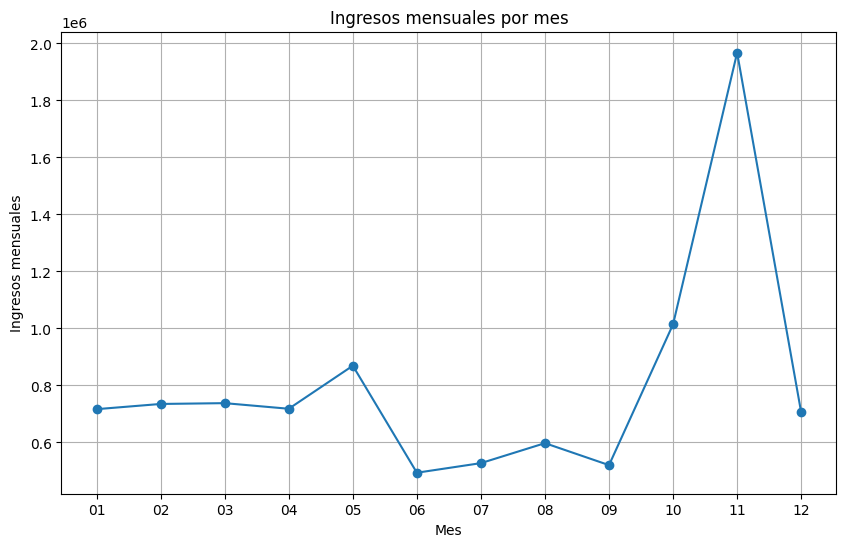

In [11]:
# Ejecutar la consulta
df_mes = pd.read_sql(q_mes, con)

# Graficar
plt.figure(figsize=(10,6))
plt.plot(df_mes['mes_num'], df_mes['ingresos_mensuales'], marker='o')
plt.xticks(df_mes['mes_num'])
plt.xlabel('Mes')
plt.ylabel('Ingresos mensuales')
plt.title('Ingresos mensuales por mes')
plt.grid(True)
plt.show()

ANÁLISIS:
### Estacionalidad de Ventas:
Meses pico: Octubre y Noviembre.

Meses bajos: Junio y Julio, nos sirve para planificar estrategias que sirvar para impulsar ventas.

Ciclos anuales: Entender patrones recurrentes del negocio y preparar el inventario.

### Estrategias de Marketing:
Campañas intensivas en meses bajos para activar ventas.

Aprovechamiento de meses naturalmente altos.

Presupuesto publicitario distribuido según estacionalidad.